<a href="https://colab.research.google.com/github/shumshersubashgautam/GravitationalLensing_Darkmatter_Neural_NetworkClassification/blob/main/Darkmatter_StrongLensing_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!cp /content/gdrive/MyDrive/dataset.zip /content/

In [4]:
!unzip -q /content/dataset.zip

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import models
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch.utils.data as data
from scipy import interp
from itertools import cycle
%matplotlib inline

Samples with no substructure: 


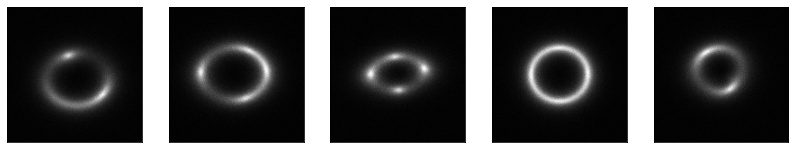

Samples with spherical substructure: 


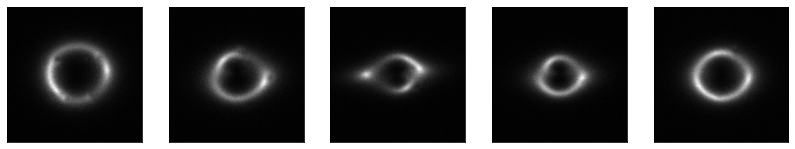

Samples with vortex substructure: 


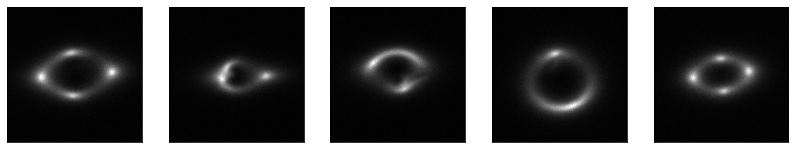

In [6]:

# Define the input paths
train_path1 = './dataset/train/no'
train_files1 = [os.path.join(train_path1, f) for f in os.listdir(train_path1) if f.endswith(".npy")]
train_path2 = './dataset/train/sphere'
train_files2 = [os.path.join(train_path2, f) for f in os.listdir(train_path2) if f.endswith(".npy")]
train_path3 = './dataset/train/vort'
train_files3 = [os.path.join(train_path3, f) for f in os.listdir(train_path3) if f.endswith(".npy")]

# Number of samples to display per class
n = 5

# Plot the samples 
i = 1
print('Samples with no substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]
for image in train_files1[:n]:
    ax = plt.subplot(3,n,i)
    plt.imshow(np.load(image).reshape(150,150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

print('Samples with spherical substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]
for image in train_files2[:n]:
    ax = plt.subplot(3,n,i)
    plt.imshow(np.load(image).reshape(150,150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

print('Samples with vortex substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]
for image in train_files3[:n]:
    ax = plt.subplot(3,n,i)
    plt.imshow(np.load(image).reshape(150,150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1

In [7]:
# Set Batch Size
batch_size = 100

# Define Data Loaders
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample
    
train_data = torchvision.datasets.DatasetFolder(root='./dataset/train', loader=npy_loader, extensions='.npy')
print("Training Classes: " + str(train_data.class_to_idx))
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_data = torchvision.datasets.DatasetFolder(root='./dataset/val', loader=npy_loader, extensions='.npy')
print("Validation Classes: " + str(val_data.class_to_idx))
val_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)


Training Classes: {'no': 0, 'sphere': 1, 'vort': 2}
Validation Classes: {'no': 0, 'sphere': 1, 'vort': 2}


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# Define the Model
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 5, stride = 2, padding = 0)
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 5, stride = 2, padding = 0)
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 2, padding = 0)
    self.linear1 = nn.Linear(480, 84)
    self.linear2 = nn.Linear(84, 3)
    self.tanh = nn.Tanh()
    self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.tanh(x)
    x = self.avgpool(x)
    x = self.conv2(x)
    x = self.tanh(x)
    x = self.avgpool(x)
    x = self.conv3(x)
    x = self.tanh(x)
    x = x.reshape(x.shape[0], -1)
    x = self.linear1(x)
    x = self.tanh(x)
    x = self.linear2(x)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [9]:
# Loss Function
criteria = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Calculate the number of batches
n_batches_train = (len(train_files1)*3)/batch_size

# Train the model
n_epochs = 50 # Number of Training Epochs
loss_array = []
pbar = tqdm(range(1, n_epochs+1))
for epoch in pbar:
    train_loss = 0.0
    train_acc = 0.0
    
    for step, (x_tr, y_tr) in enumerate(train_data_loader):

        data = Variable(x_tr).type(torch.cuda.FloatTensor)
        if torch.cuda.is_available():
          data = data.cuda()
        labels = torch.tensor(y_tr, dtype=torch.long, device=device)
        optimizer.zero_grad()
        outputs = model(data)
        _, preds = torch.max(model(data).data, 1)
        correct = (preds == labels).float().sum()
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss
        train_acc += correct/data.shape[0]

    train_loss = train_loss/n_batches_train
    train_acc = train_acc/n_batches_train
    # Display the Training Stats
    pbar.set_postfix({ 'Training Loss': train_loss.item(), 'Training Acc': train_acc.item() })

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-9-ce7cd456b1fb>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(y_tr, dtype=torch.long, device=device)


In [10]:
y_score = []
y_test = []
for _, (x_ts, y_ts) in enumerate(val_data_loader):

    mini_val_data = Variable(x_ts).type(torch.cuda.FloatTensor)
    if torch.cuda.is_available():
      mini_val_data = mini_val_data.cuda()
    y_score.append(torch.nn.functional.softmax(model(mini_val_data), dim=1).cpu().detach().numpy())
    y_test.append(y_ts.cpu().detach().numpy())

y_score = np.asarray(y_score).reshape(-1,3)
y_val = np.asarray(y_test).reshape(-1)
y_val = label_binarize(y_val, classes=[0, 1, 2])

<ipython-input-11-ee82031907e9>:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


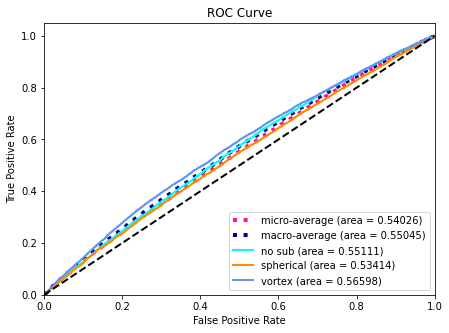

In [11]:
n_classes = y_val.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.figsize'] = [7, 5]
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {})'
               ''.format(round(roc_auc["micro"],5)),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {})'
               ''.format(round(roc_auc["macro"],5)),
         color='navy', linestyle=':', linewidth=4)

labels = ['no sub', 'spherical', 'vortex']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{} (area = {})'
             ''.format(labels[i], round(roc_auc[i],5)))

# Plot the ROC 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={"size":10})